# TODO
 * ~~Predict on test data to submit results~~
 * ~~Try using an autoencoded (trained on our image dataset) image feature detector instead of VGG~~
 * ~~Add Global Average Pooling~~
 * Loss function taking care of the 3 classes (uses `getCategory()` function to compare prediction vs target). Also modify the function to add other categories: colors, actions (standing, baseball, soccer, playing, etc..), directions (left, right)
 * ~~Print some stats about the dataset: classes quantities~~
 * Try GloVe instead of W2V (https://medium.com/@sarin.samarth07/glove-word-embeddings-with-keras-python-code-52131b0c8b1d)

In [1]:
# Run this cell only if you are using Colab with Drive
# Run each time you initialize a machine
from google.colab import drive
drive.mount('/content/drive')

!unzip '/content/drive/My Drive/Datasets/VQA_Dataset.zip' > /dev/null
!unzip "/content/drive/My Drive/Datasets/saved_encoder.zip" > /dev/null

Mounted at /content/drive


In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import PIL
import json
import glob

img_pre = keras.preprocessing.image

from os import path

DIR = path.abspath(path.curdir)

# set seed
seed = 1234
tf.random.set_seed(seed)
np.random.seed(seed)

# Constants

img_size = (400, 700, 3)

labels_dict = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}

num_classes = len(labels_dict)

In [33]:
# Hyper-parameters
# ------------------

# Word2Vec
max_sentence_length = 30
using_glove = True
glove_dimensions = 100 # One of 50, 100, 200, 300, it is the vector size of the output

# Training
batch_size = 32
validation_split = 0.1
finetuning = False

epochs = 100
steps_per_epoch = 52948 / batch_size # len(dataset) * (1 - validation_split) = ~52948
validation_steps = 5883 / batch_size # len(dataset_valid) * validation_split = ~5883

# Network
using_vgg = False
hidden_neurons = 128
hidden_layers = 2

add_dropout = 0 # 0 to turn it off
first_n_layers_of_encoder = 9 # 9 is last MaxPolling, 10 also involves Dense

# LSTM
lstm_n_units = 32 # 128
lstm_n_layers = 4 # 1
lstm_use_bidirectional = True

# Early Stopping
early_stop = True
monitor = 'val_loss'
patience = 20

In [ ]:
# Initialize the embeddings
!cp /content/drive/My\ Drive/Datasets/word2vec.model .

from gensim.models import Word2Vec

model_w2v = Word2Vec.load("word2vec.model")

w2v_vector_size = model_w2v.vector_size

# Tests
print(model_w2v.wv.most_similar(positive=["red"]))
print(model_w2v.wv.most_similar(positive=["man"]))
print(model_w2v.wv.most_similar(positive=["right"]))

[('black', 0.6762123107910156), ('gray', 0.6468334794044495), ('blue', 0.6462243795394897), ('white', 0.48647937178611755), ('tan', 0.4814988076686859), ('short-sleeved', 0.40863439440727234), ('sleeve', 0.40561360120773315), ("ground's", 0.39801156520843506), ('lefts', 0.3812544643878937), ('outlines', 0.37935036420822144)]
[('boy', 0.8407500982284546), ('woman', 0.7949094176292419), ('lady', 0.794099748134613), ('guy', 0.7156769037246704), ('girl', 0.6591890454292297), ('kid', 0.6141188144683838), ('child', 0.6076536178588867), ('person', 0.6047650575637817), ('baby', 0.5876283645629883), ('couple', 0.5469201803207397)]
[('left', 0.8639363050460815), ('couch', 0.4216926097869873), ('top', 0.4098255932331085), ('whom', 0.36560308933258057), ('old', 0.36172735691070557), ('slide', 0.3599586486816406), ('bench', 0.35730648040771484), ('football', 0.35334649682044983), ('young', 0.35247236490249634), ('bike', 0.34030652046203613)]


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip
# Don't run if you don't use Glove, it is unnecessary

In [18]:
if using_glove:
    path_to_glove_file = "./glove.6B." + str(glove_dimensions) + "d.txt"

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))
    glove_vector_size = len(embeddings_index.get("the"))


Found 400000 word vectors.


In [15]:
print(len(embeddings_index.get("the")))

100


In [19]:
from collections import defaultdict, OrderedDict

# Some data collection
with open(path.join(DIR, "train_questions_annotations.json")) as file:
    loaded = json.load(file).values()
    train_questions = [x["question"] for x in loaded]
    train_answers = [x["answer"] for x in loaded]

class_counts = defaultdict(lambda: 0)
for index in range(len(train_questions)):
    class_counts[train_answers[index]] += 1
total = sum(class_counts.values())
weights = {k: v/total for k,v in class_counts.items()}
weights

{'0': 0.01009654609736198,
 '1': 0.04167799836823497,
 '2': 0.07563910796845254,
 '3': 0.028725863475659506,
 '4': 0.013479059015501768,
 '5': 0.008073837367419092,
 'apple': 0.003314522708729943,
 'baseball': 0.002821593690508567,
 'bench': 0.0034844982322545554,
 'bike': 0.003059559423443024,
 'bird': 0.003518493336959478,
 'black': 0.006238101713353277,
 'blanket': 0.003467500679902094,
 'blue': 0.013666032091378842,
 'bone': 0.0030255643187381016,
 'book': 0.0029405765569757956,
 'boy': 0.0038414468316562414,
 'brown': 0.011864291542017949,
 'cat': 0.009501631765025836,
 'chair': 0.002974571661680718,
 'couch': 0.005167255915148218,
 'dog': 0.011609328256731031,
 'floor': 0.005677182485722056,
 'food': 0.004572341582812075,
 'football': 0.005014277943976068,
 'girl': 0.004130405221648083,
 'grass': 0.003467500679902094,
 'gray': 0.00600013598041882,
 'green': 0.0064590698939352735,
 'left': 0.004759314658689149,
 'log': 0.004028419907533315,
 'man': 0.0036544737557791676,
 'monkey 

In [20]:
def getCategory(answer):
    if answer in ['yes', 'no']:
        return ['yes/no']
    elif answer in [str(i) for i in range(6)]:
        return ['counting']
    elif answer in ['playing', 'sitting', 'sleeping', 'standing']:
        return ['action']
    elif answer in ['watermelon', 'pizza', 'pie', 'apple', 'food', 'wine']:
        return ['edible', 'object']
    elif answer in ['yellow', 'red', 'orange', 'green', 'gray', 'brown', 'blue', 'black', 'white']:
        return ['color']
    elif answer in ['cat', 'dog', 'squirrel', 'bird', 'boy', 'girl', 'woman', 'man']:
        return ['animal','object'] # Stuff that walks and stuff
    elif answer in ['soccer', 'football', 'baseball']:
        return ['sport']
    elif answer in ['bench', 'chair', 'couch', 'floor', 'table', 'stool', 'rug', 'blanket', 'grass', 'log', 'monkey bars', 'sandbox', 'tree']:
        return ['sittable', 'object'] # Sittables are also locations
    elif answer == "bike":
        return ['object', 'transport']
    elif answer == 'nothing':
        return ['object', 'action']
    elif answer in ['left', 'right']:
        return ['direction']
    elif answer in ['plant', 'bone', 'book']:
        return ['object']
    elif answer == "sunny":
        return ['weather']
    else:
        return 'other'


In [21]:
coef_matrix = []
commons = ["2", "red", "yes"] #the most common words
for word_true in labels_dict.keys():
    coef_row = []
    for word_pred in labels_dict.keys():
        true_props, pred_props = getCategory(word_true), getCategory(word_pred)
        coef = 2.0
        if all(true_prop in pred_props for true_prop in true_props):
            coef = 1.0 # Correct categorization
        elif ("object" in true_props or "action" in true_props) and word_pred == "nothing":
            coef = 1.0 # We can predict nothing for actions or objects
        if word_pred in commons and word_true not in commons:
            coef = 3.0 # We predicted a common while the true value is not
        coef_row.append(coef)
    coef_matrix.append(coef_row)

In [22]:
orig_loss = tf.keras.losses.CategoricalCrossentropy()
tf_weights = tf.constant(list(weights.values()))
tf_coefs = tf.constant(coef_matrix)
def custom_loss(y_true, y_pred):
    true_class = tf.math.argmax(y_true)
    pred_class = tf.math.argmax(y_pred)
    class_weight_coef = 1 / (tf.gather(tf_weights, pred_class) / tf.gather(tf_weights, true_class))
    category_coef = tf.gather(tf.gather(tf_coefs, true_class), pred_class)
    # print("True", true_class)
    # print("Pred", pred_class)
    # print("Class weights",class_weight_coef)
    # print("Category coefficients",category_coef)
    return orig_loss(y_true, y_pred) * class_weight_coef * category_coef

In [23]:
import tensorflow.keras.backend as K
red_true = [0.0] * num_classes
red_true[39] = 1.0
predict_red = [0.0] * num_classes
predict_red[39] = 0.7
predict_red[0] = 0.2
predict_red[23] = 0.1

black_true = [0.0] * num_classes
black_true[11] = 1.0

predict_black = [0.0] * num_classes
predict_black[11] = 0.7
predict_black[2] = 0.2
predict_black[39] = 0.1


predict_no = [0.0] * num_classes
predict_no[labels_dict["no"]] = 0.7
predict_no[3] = 0.2
predict_no[2] = 0.1

predict_yes = [0.0] * num_classes
predict_yes[labels_dict["yes"]] = 0.7
predict_yes[labels_dict["no"]] = 0.2
predict_yes[2] = 0.1

loss_eval = lambda t_val, p_val: K.eval(custom_loss(K.variable(t_val), K.variable(p_val)))

red_correct_loss = loss_eval(red_true, predict_red)
print("Common correct", red_correct_loss)
print()
red_incorrect_loss = loss_eval(red_true, predict_black)
print("Common same category, guessed uncommon", red_incorrect_loss)
print()

black_loss = loss_eval(black_true, predict_red)
print("Uncommon incorrect, guessed common", black_loss)
print()

black_correct_loss = loss_eval(black_true, predict_black)
print("Uncommon correct", black_correct_loss)
print()

black_guess_no = loss_eval(black_true, predict_no)
print("Uncommon incorrect, guessed uncommon, incorrect category", black_guess_no)
print()

black_guess_yes = loss_eval(black_true, predict_yes)
print("Uncommon incorrect, guessed common, incorrect category", black_guess_yes)


Common correct 0.35667497

Common same category, guessed uncommon 1.2601986

Uncommon incorrect, guessed common 88.351036

Uncommon correct 0.35667497

Uncommon incorrect, guessed uncommon, incorrect category 73.39932

Uncommon incorrect, guessed common, incorrect category 103.716446


In [26]:
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(np.array(list(labels_dict.keys())).reshape(-1, 1))
sentence_vector_size = glove_vector_size if using_glove else w2v_vector_size
UNKNOWN = [0] * sentence_vector_size
# Custom Dataset needed to handle the tuples (image, question, answer)
class CustomDataset(tf.keras.utils.Sequence):
    """
      CustomDataset inheriting from tf.keras.utils.Sequence.

      3 main methods:
        - __init__: save dataset params like directory, filenames..
        - __len__: return the total number of samples in the dataset
        - __getitem__: return a sample from the dataset (image, question, answer)

      Note:
        - the custom dataset return a single sample from the dataset. Then, we use
          a tf.data.Dataset object to group samples into batches.
        - in this case we have a different structure of the dataset in memory.
          We have all the images in the same folder and the training and validation splits
          are defined in text files.

    """

    def __init__(self, which_subset, img_generator=None,
                 preprocessing_function=None, out_shape=[256, 256], validation_split=0.2):
                
        with open(path.join(DIR, "train_questions_annotations.json")) as file:
            loaded = json.load(file).values()
            train_questions = [x["question"] for x in loaded]
            train_images = [x["image_id"] for x in loaded]
            train_answers = [x["answer"] for x in loaded]

        # Build sentences to find the embedding in Word2Vec (as in the challenge3Word2VecEncodings.ipynb)
        sentences = []
        for i in train_questions:
            sentences.append(i.replace('?', '').lower().split(' '))

        # Convert the string sentences in word2vec embeddings
        sentences_vectorized = []
        for sentence in sentences:
            sentence_vectorized = []
            for word in sentence:
                if using_glove:
                    vector = embeddings_index.get(word)
                    if vector is None:
                        vector = UNKNOWN # W2v is trained on our words so it will have all the words
                else:
                    vector = model_w2v.wv[word]
                sentence_vectorized.append(vector)
            # Add the padding
            if (len(sentence) <= max_sentence_length):
                padding_needed = max_sentence_length - len(sentence_vectorized)
                pad = [0] * sentence_vector_size
                for _ in range(padding_needed):
                    sentence_vectorized.append(pad)
            else:
                raise ValueError("len(sentence) = " + str(len(sentence)))
            sentences_vectorized.append(sentence_vectorized)

        # Split the indexes of the training and the validation sets
        split_index = int((1 - validation_split) * len(sentences_vectorized))
        if which_subset == 'training':
            subset_images = train_images[:split_index]
            subset_questions = sentences_vectorized[:split_index]
            subset_answers = train_answers[:split_index]
        elif which_subset == 'validation':
            subset_images = train_images[split_index:]
            subset_questions = sentences_vectorized[split_index:]
            subset_answers = train_answers[split_index:]
        else:
            raise ValueError()

        self.train_questions = train_questions
        self.train_images = train_images
        self.train_answers = train_answers
        self.which_subset = which_subset
        self.subset_images = subset_images
        self.subset_questions = subset_questions
        self.subset_answers = subset_answers
        self.img_generator = img_generator
        self.preprocessing_function = preprocessing_function
        self.out_shape = out_shape
        self.sentences_vectorized = sentences_vectorized

    def __len__(self):
        return len(self.subset_questions)

    def __getitem__(self, index):
        img = Image.open(path.join("./Images", self.subset_images[index] + ".png")).convert("RGB")
        img_arr = np.array(img)
        if self.preprocessing_function:
            img_arr = self.preprocessing_function(img_arr)
        else: # if no processing function is passed we prepocess as in challenge3ImageAutoencoder.ipynb
            img_arr = img_arr.astype('float64')
            img_arr *= 1./255
            img_arr -= .5
        img_arr = np.expand_dims(img_arr, axis=0)


        sentence_vectorized = self.subset_questions[index]
        sentence_vectorized = np.expand_dims(sentence_vectorized, axis=0)
        answer_vectorized = one_hot_encoder.transform(np.array([self.subset_answers[index]]).reshape(-1, 1))[0]
        answer_vectorized = np.expand_dims(answer_vectorized, axis=0)
        return (img_arr, sentence_vectorized), answer_vectorized

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input 

if using_vgg:
    train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)  # to apply vgg normalization
    dataset = CustomDataset('training', img_generator=train_data_gen, validation_split=validation_split, preprocessing_function=preprocess_input)
else:
    train_data_gen = ImageDataGenerator()
    dataset = CustomDataset('training', img_generator=train_data_gen, validation_split=validation_split)

if using_vgg:
    valid_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)  # to apply vgg normalization
    dataset_valid = CustomDataset('validation', img_generator=valid_data_gen, validation_split=validation_split, preprocessing_function=preprocess_input)
else:
    valid_data_gen = ImageDataGenerator()
    dataset_valid = CustomDataset('validation', img_generator=valid_data_gen, validation_split=validation_split)


train_dataset = tf.data.Dataset.from_generator(lambda: dataset,
                                               output_types=((tf.float64, tf.float64), tf.float64),
                                               output_shapes=(([None, img_size[0], img_size[1], img_size[2]], [None, max_sentence_length, sentence_vector_size]), [None, num_classes]))
train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: dataset_valid,
                                               output_types=((tf.float64, tf.float64), tf.float64),
                                               output_shapes=(([None, img_size[0], img_size[1], img_size[2]], [None, max_sentence_length, sentence_vector_size]), [None, num_classes]))
valid_dataset = valid_dataset.repeat()


In [28]:
from keras import Model
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from keras.models import load_model
# Create the model
# ----------------------
if using_vgg:
    vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=img_size)

    if finetuning:
        freeze_until = 15 # layer from which we want to fine-tune
        
        for layer in vgg.layers[:freeze_until]:
            layer.trainable = False
    else:
        vgg.trainable = False
else:
    vgg = load_model("./saved_encoder")
    vgg.trainable = True
    for layer in vgg.layers:
        layer._name = layer.name + "_encoder"


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_encoder (InputLayer)    [(None, 400, 700, 3) 0                                            
__________________________________________________________________________________________________
resizing_encoder (Resizing)     (None, 400, 800, 3)  0           input_1_encoder[0][0]            
__________________________________________________________________________________________________
conv2d_encoder (Conv2D)         (None, 400, 800, 8)  224         resizing_encoder[0][0]           
__________________________________________________________________________________________________
max_pooling2d_encoder (MaxPooli (None, 200, 400, 8)  0           conv2d_encoder[0][0]             
____________________________________________________________________________________________

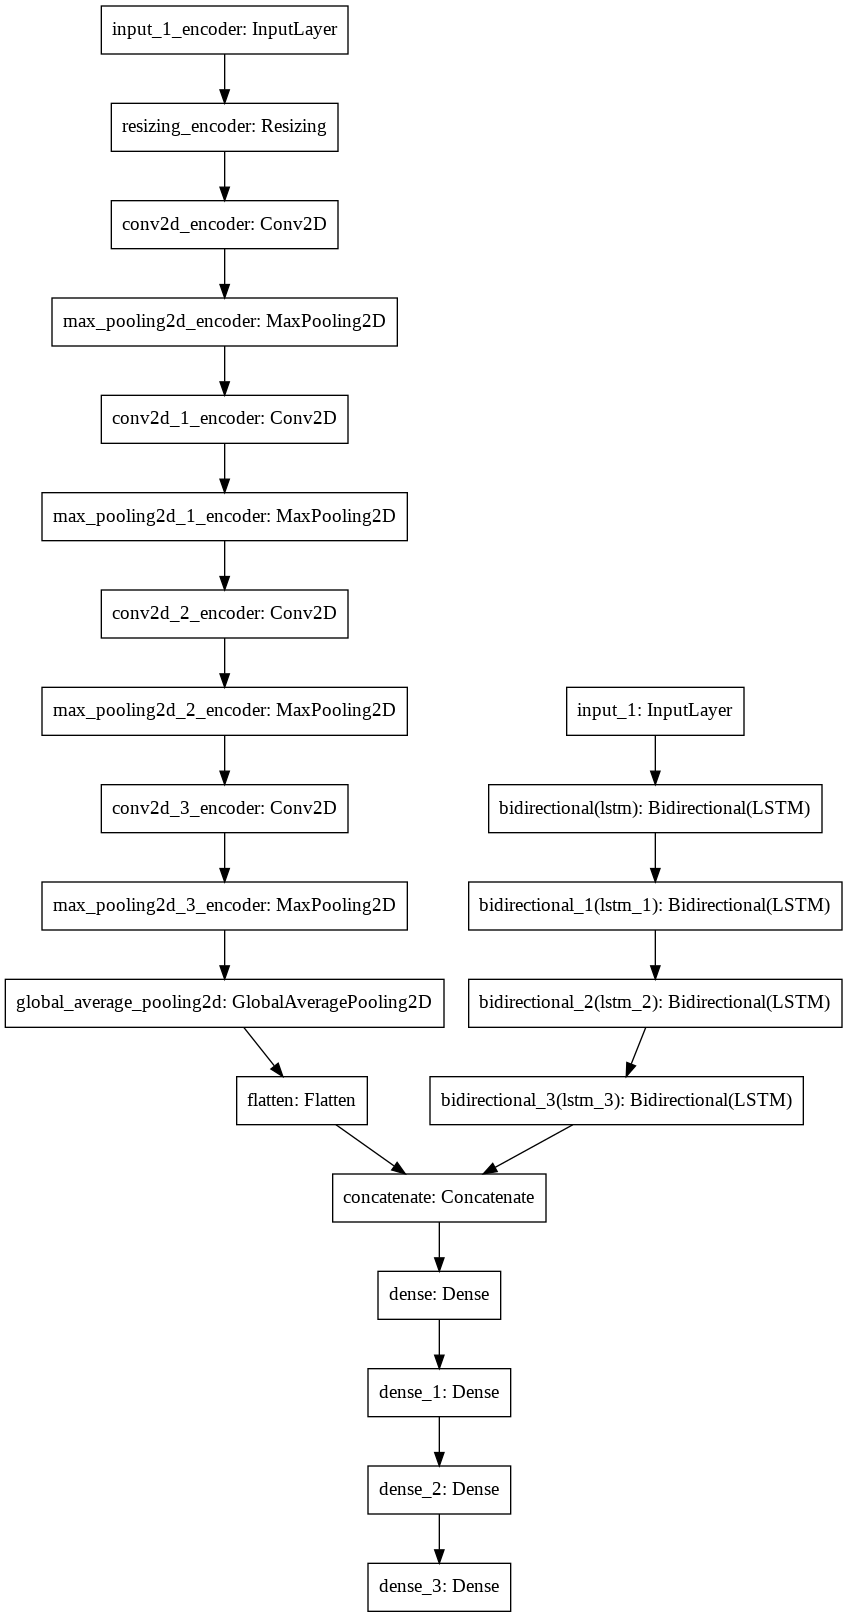

In [29]:
# Image network
# ----------------------
gap = tf.keras.layers.GlobalAveragePooling2D()(vgg.layers[first_n_layers_of_encoder].output)
out_img = tf.keras.layers.Flatten()(gap) # Flatten needed for the Concatenate to match the tensor size of the LSTM 
x = Model(inputs=vgg.input, outputs=out_img)

# Text network
# ----------------------
text_input = tf.keras.Input(shape=[max_sentence_length, sentence_vector_size])
lstm_input = text_input
for i in range(lstm_n_layers):
    lstm = tf.keras.layers.LSTM(units=lstm_n_units, return_state=True, return_sequences= i + 1 != lstm_n_layers)
    if lstm_use_bidirectional:
        lstm = tf.keras.layers.Bidirectional(lstm)
    lstm_output = lstm(lstm_input)
    if lstm_use_bidirectional:
        lstm_output = lstm_output[0]
    lstm_input = lstm_output

#lstm1_states = [h, c]
y = Model(inputs=text_input, outputs=lstm_output)

# Dense network
# ----------------------
z = tf.keras.layers.Concatenate(axis=1)([x.output, y.output])
for i in range(hidden_layers):
    z = tf.keras.layers.Dense(hidden_neurons, activation="relu")(z)
    if add_dropout:
        z = tf.keras.layers.Dropout(add_dropout)(z)
z = tf.keras.layers.Dense(hidden_neurons, activation="sigmoid")(z)
z = tf.keras.layers.Dense(num_classes, activation='softmax')(z)
model = Model(inputs=[x.input, y.input], outputs=z)

model.summary()


tf.keras.utils.plot_model(model)

In [30]:
# Optimization params
# -------------------

# Loss
# loss = tf.keras.losses.CategoricalCrossentropy()
loss = custom_loss
# learning rate
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [31]:
# Training 
# ----------------------
import os
from datetime import datetime

exps_dir = os.path.join(path.curdir, 'logs')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'VQA'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience)
    callbacks.append(es_callback)


# How to visualize Tensorboard

# 1. tensorboard --logdir EXPERIMENTS_DIR --port PORT     <- from terminal
# 2. localhost:PORT   <- in your browser


In [ ]:
model.fit(x=train_dataset,
          epochs=epochs,
          batch_size=batch_size,
          steps_per_epoch=len(dataset) // batch_size, 
          validation_data=valid_dataset,
          validation_steps=len(dataset_valid) // batch_size, 
          callbacks=callbacks)

Epoch 1/100
1654/1654 [==============================] - 59s 35ms/step - loss: 5.4606 - accuracy: 0.2914 - val_loss: 5.4162 - val_accuracy: 0.3060
Epoch 2/100
1654/1654 [==============================] - 58s 35ms/step - loss: 5.4408 - accuracy: 0.3041 - val_loss: 5.3015 - val_accuracy: 0.3060
Epoch 3/100
1654/1654 [==============================] - 58s 35ms/step - loss: 5.3915 - accuracy: 0.3253 - val_loss: 5.3226 - val_accuracy: 0.3060
Epoch 4/100
1654/1654 [==============================] - 57s 35ms/step - loss: 5.4775 - accuracy: 0.2733 - val_loss: 5.2644 - val_accuracy: 0.3060
Epoch 5/100
1654/1654 [==============================] - 58s 35ms/step - loss: 5.3198 - accuracy: 0.3241 - val_loss: 5.3667 - val_accuracy: 0.3060
Epoch 6/100
1654/1654 [==============================] - 59s 36ms/step - loss: 5.4161 - accuracy: 0.2920 - val_loss: 5.3477 - val_accuracy: 0.3060
Epoch 7/100
1654/1654 [==============================] - 60s 36ms/step - loss: 5.4125 - accuracy: 0.3114 - val_loss: 5

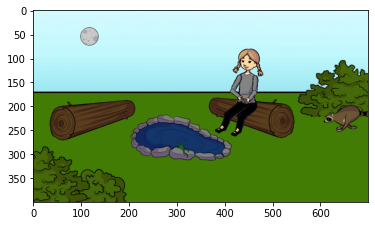

In [ ]:
import matplotlib.pyplot as plt
i = iter(dataset_valid)

img = next(i)[0][0].reshape((400, 700, 3))

plt.imshow(img)
plt.show()

In [ ]:
# Save the model
!mkdir ./saved_model3/
!mkdir ./saved_model3/weights
model.save_weights('./saved_model3/weights')
!zip -o -r saved_model3.zip ./saved_model3/

  adding: saved_model3/ (stored 0%)
  adding: saved_model3/weights/ (stored 0%)
  adding: saved_model3/checkpoint (deflated 37%)
  adding: saved_model3/weights.index (deflated 77%)
  adding: saved_model3/weights.data-00000-of-00001 (deflated 22%)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Print the confusion matrix from the validation test

y_pred = []
y_true = []
i = 0
for sample in valid_dataset:
    y_pred.append(model.predict(sample[0]))
    y_true.append(sample[1])
    i += 1
    if i > len(dataset_valid):
        break

print(i)
#y_pred = np.argmax(y_pred, axis=1)
c = []
for a in y_pred:
    b = np.zeros_like(a)
    b[np.arange(len(a)), a.argmax(1)] = 1
    c.append(b)
y_pred = c
y_true_int = []
for row in y_true:
    y_true_int.append([np.where(r==1)[0][0] for r in row])
y_pred_int = []
for row in y_pred:
    y_pred_int.append([np.where(r==1)[0][0] for r in row])

print('Confusion Matrix')
print(confusion_matrix(y_true=y_true_int, y_pred=y_pred_int))
print('Classification Report')
target_names = list(labels_dict.keys())
print(classification_report(y_true=y_true_int, y_pred=y_pred_int, target_names=target_names))

5885
Confusion Matrix
[[   0    0   51 ...    0    0    0]
 [   0    0  219 ...    0    0    1]
 [   0    0  452 ...    1    0    0]
 ...
 [   0    0    0 ...    0    0    5]
 [   0    0    0 ...    0   40    0]
 [   0    0    1 ...    0    0 1861]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.00      0.00      0.00       220
           2       0.45      0.99      0.62       456
           3       0.00      0.00      0.00       146
           4       0.00      0.00      0.00        88
           5       0.00      0.00      0.00        44
       apple       0.06      0.06      0.06        17
    baseball       0.00      0.00      0.00        14
       bench       0.00      0.00      0.00         6
        bike       0.10      0.50      0.17        12
        bird       0.31      0.31      0.31        13
       black       0.00      0.00      0.00        49
     blanket       0.00  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Create the results file to submit

import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')

In [ ]:
def saveTestValues(model):
    with open(path.join(DIR, "test_questions.json")) as file:
        loads = json.load(file)
        test_question_ids = list(loads.keys())
        loaded = loads.values()
        test_questions = [x["question"] for x in loaded]
        test_images = [x["image_id"] for x in loaded]
    # Build sentences to find the embedding in Word2Vec (as in the challenge3Word2VecEncodings.ipynb)
    sentences = [i.replace('?', '').lower().split(' ') for i in test_questions]
    # Convert the string sentences in word2vec embeddings
    def vectorize_sentence(sentence:str):
        if using_glove:
            def get_vector(word):
                vector = embeddings_index.get(word)
                if vector is None:
                    vector = UNKNOWN
                return vector
            vectorized_sentence = [get_vector(word) for word in sentence]
        else:
            vectorized_sentence = [model_w2v.wv[word] for word in sentence if word in model_w2v.wv]
        padding_amount = max_sentence_length - len(vectorized_sentence)
        padding = [0] * sentence_vector_size
        for _ in range(padding_amount):
            vectorized_sentence.append(padding)
        return vectorized_sentence
    vectorized_sentences = [vectorize_sentence(sentence) for sentence in sentences]
    results = {}
    i = 0
    for index in range(len(test_questions)):
        img_path = path.join("./Images", test_images[index] + ".png")
        #print(img_path)
        img = Image.open(img_path).convert("RGB")
        img_arr = np.array(img)
        if using_vgg:
            img_arr = preprocess_input(img_arr)
        else: # if not using vgg we prepocess as in challenge3ImageAutoencoder.ipynb
            img_arr = img_arr.astype('float64')
            img_arr *= 1./255
            img_arr -= .5
        img_arr = np.expand_dims(img_arr, axis=0)

        vectorized_sentence = vectorized_sentences[index]
        #print(vectorize_sentence != vectorized_sentences[index + 1])
        vectorized_sentence = np.expand_dims(vectorized_sentence, axis=0)
        prediction_result = model.predict((img_arr, vectorized_sentence))
        #print(prediction_result)
        res = (prediction_result[0]).argmax(axis=0)
        #print(sentences[index])
        #print(list(labels_dict)[res])
        results[test_question_ids[index]] = res
        i += 1
    create_csv(results)
    print(i)

In [ ]:
saveTestValues(model)

6372
